In [36]:
import os
import re
import numpy as np 
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [37]:
home_dir = '/kaggle/input/utkface-new/UTKFace'

# Modelo a ser utilizado
cnn_modelo = "InceptionV3"  # Modelos disponíveis: InceptionV3, MobileNetV2, ResNet50, EfficientNetB0, cnn_tcc_will

EPOCHS = 50  # Limitado para não ultrapassar tempo do Kaggle

# Set the data generators
BATCH_SIZE=64

print(f"Versão do TensorFlow: {tf.__version__}")
print(f"Modelo Selecionado: {cnn_modelo}")

Versão do TensorFlow: 2.17.1
Modelo Selecionado: InceptionV3


In [38]:
if cnn_modelo == "InceptionV3":
    from tensorflow.keras.applications import InceptionV3
    
elif cnn_modelo == "MobileNetV2":
    from tensorflow.keras.applications import MobileNetV2
    
elif cnn_modelo == "ResNet50":
    from tensorflow.keras.applications import ResNet50
    
elif cnn_modelo == "EfficientNetB0":
    from tensorflow.keras.applications import EfficientNetB0
elif cnn_modelo == "cnn_tcc_will":
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
else:
    print(f"{cnn_modelo} não lib não localizada")

In [39]:
def load_dataset(directory):
    paths = []
    ages = []
    ignored_files = 0
    ignored_examples = []  # Lista para armazenar arquivos ignorados
    
    for filename in tqdm(sorted(os.listdir(directory))):  # Ordenar para consistência
        try:
            match = re.match(r'^(\d+)', filename)  # Captura somente a idade
            if not match:
                raise ValueError(f"Formato inválido: {filename}")
                
            age = int(match.group(1))
            if not (0 < age < 100):  # Filtrar idades inválidas
                raise ValueError(f"Idade fora do intervalo: {filename}")
                
            paths.append(os.path.join(directory, filename))
            ages.append(age)
        except (ValueError, IndexError, OSError) as e:
            ignored_files += 1
            ignored_examples.append(filename)

    print(f"Arquivos ignorados em {directory}: {ignored_files}")
    if ignored_files > 0:
        print(f"Exemplos ignorados: {ignored_examples[:5]}")  # Mostrar até 5 exemplos

    return pd.DataFrame({'path': paths, 'age': ages})


In [40]:
# Carregar ambos datasets
df = load_dataset(home_dir)

# Verificar se os datasets carregaram corretamente
print(f"UTKFace dataset: {df.shape[0]} imagens carregadas")


# Exibir algumas amostras para checagem
print("UTKFace dataset (amostras):")
print(df.head())

  0%|          | 0/23708 [00:00<?, ?it/s]

Arquivos ignorados em /kaggle/input/utkface-new/UTKFace: 32
Exemplos ignorados: ['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg', '100_1_0_20170112213001988.jpg.chip.jpg', '100_1_0_20170112213303693.jpg.chip.jpg']
UTKFace dataset: 23676 imagens carregadas
UTKFace dataset (amostras):
                                                path  age
0  /kaggle/input/utkface-new/UTKFace/10_0_0_20161...   10
1  /kaggle/input/utkface-new/UTKFace/10_0_0_20170...   10
2  /kaggle/input/utkface-new/UTKFace/10_0_0_20170...   10
3  /kaggle/input/utkface-new/UTKFace/10_0_0_20170...   10
4  /kaggle/input/utkface-new/UTKFace/10_0_0_20170...   10


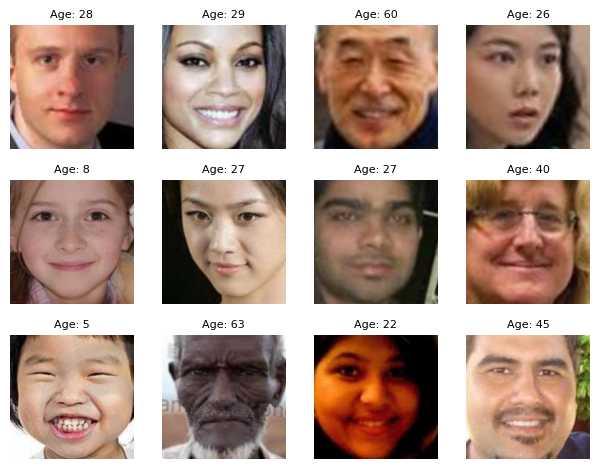

In [41]:
# Display 12 random images
data_sample = df.sample(12).reset_index(drop=True)
       # Display 12 random images
data_sample = df.sample(12).reset_index(drop=True)
       
for i in range(0, 12):
    path = data_sample.loc[i, 'path']
    age = data_sample.loc[i, 'age']
    img = plt.imread(path)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f'Age: {age}', fontsize=8)
    plt.axis('off')
plt.tight_layout()
for i in range(0, 12):
    path = data_sample.loc[i, 'path']
    age = data_sample.loc[i, 'age']
    img = plt.imread(path)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f'Age: {age}', fontsize=8)
    plt.axis('off')
plt.tight_layout()

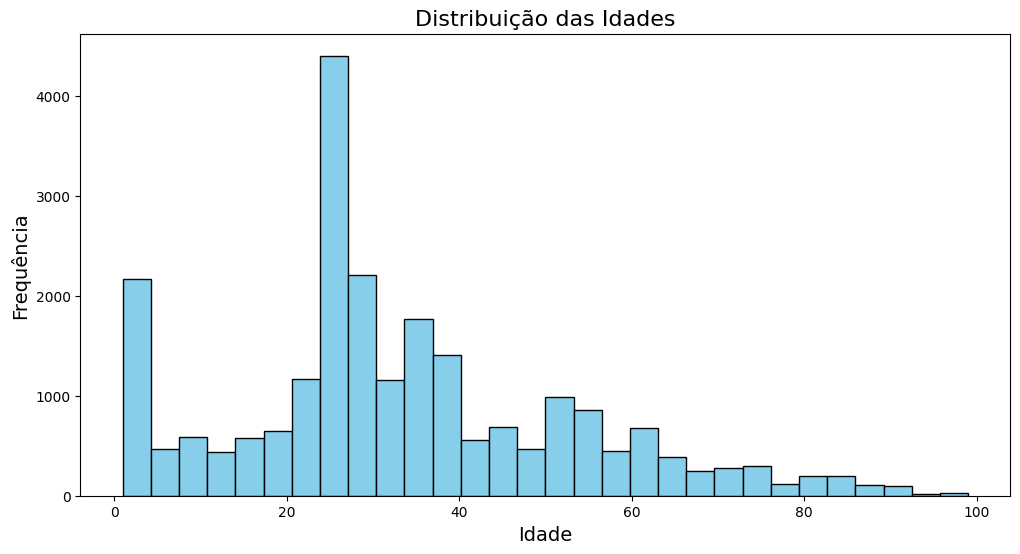

In [42]:
df['age'] = df['age'].replace([np.inf, -np.inf], np.nan)

# Configura o tamanho da figura
plt.figure(figsize=(12, 6))

# Cria o histograma
plt.hist(df['age'].dropna(), bins=30, color='skyblue', edgecolor='black')

# Adiciona título e rótulos aos eixos
plt.title('Distribuição das Idades', fontsize=16)
plt.xlabel('Idade', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Exibe o gráfico
plt.show()

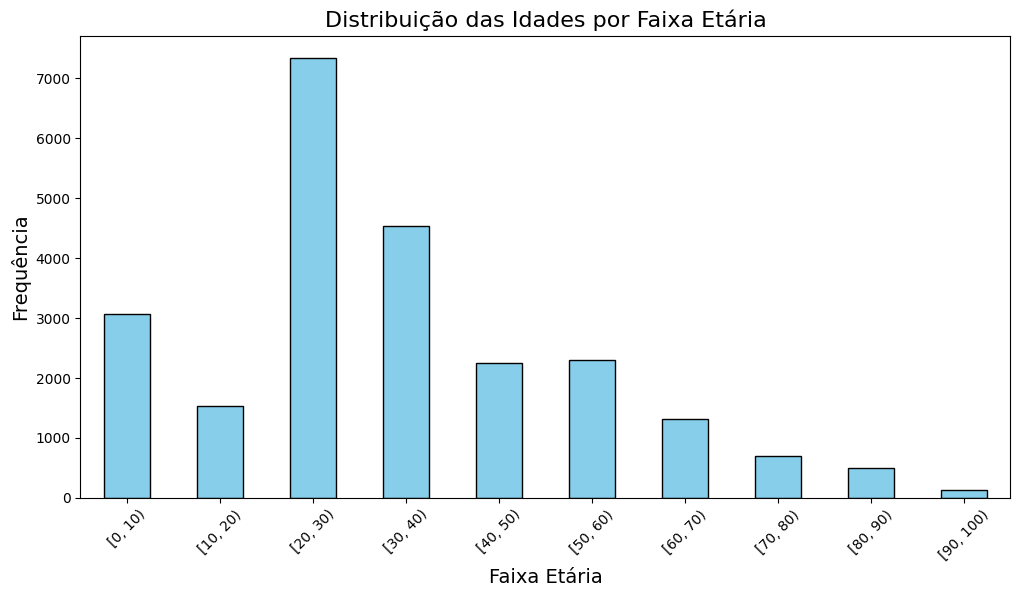

In [43]:
# Cria faixas etárias de 10 em 10 anos
df['faixa_etaria'] = pd.cut(df['age'], bins=range(0, 101, 10), right=False)

# Conta a frequência de cada faixa etária
contagem_faixas = df['faixa_etaria'].value_counts().sort_index()

# Plota o gráfico de barras
plt.figure(figsize=(12, 6))
contagem_faixas.plot(kind='bar', color='skyblue', edgecolor='black')

# Adiciona título e rótulos
plt.title('Distribuição das Idades por Faixa Etária', fontsize=16)
plt.xlabel('Faixa Etária', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização

# Exibe o gráfico
plt.show()

In [44]:
# Split the data to train, validation and split datasets 
X_train, X_test_val = train_test_split(df, test_size=0.2, random_state=7)

# Split test and val evenly
X_test, X_val = train_test_split(X_test_val, test_size=0.5, random_state=7)


In [45]:
datagen_train = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.25],
    fill_mode='nearest'
)

datagen_val_test = ImageDataGenerator(rescale=1/255.)

In [46]:
class CustomDataGenerator(Sequence):
    def __init__(self, generator, workers=1, use_multiprocessing=False, max_queue_size=10, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.workers = workers  # Armazena o valor de workers
        self.use_multiprocessing = use_multiprocessing  # Armazena o valor de use_multiprocessing
        self.max_queue_size = max_queue_size  # Armazena o valor de max_queue_size

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        images, labels = self.generator[index]
        return images, {'age_out': labels}

    def on_epoch_end(self):
        self.generator.on_epoch_end()

In [47]:
train_generator = CustomDataGenerator(
    datagen_train.flow_from_dataframe(
        dataframe=X_train,
        x_col='path',
        y_col='age',  # Alterado para única saída
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw'  # Modo para regressão única
    ),
    workers=4,
    use_multiprocessing=True,
    max_queue_size=20
)
val_generator = CustomDataGenerator(
    datagen_val_test.flow_from_dataframe(
        dataframe=X_val,
        x_col='path',
        y_col='age',  # Alterado
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw'  # Alterado
    ),
    workers=4,  # Passe os argumentos workers, use_multiprocessing e max_queue_size AQUI
    use_multiprocessing=True,
    max_queue_size=20
)

test_generator = CustomDataGenerator(
    datagen_val_test.flow_from_dataframe(
        dataframe=X_test,
        x_col='path',
        y_col='age',  # Alterado
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw'  # Alterado
    ),
    workers=4,  # Passe os argumentos workers, use_multiprocessing e max_queue_size AQUI
    use_multiprocessing=True,
    max_queue_size=20
)


Found 18940 validated image filenames.
Found 2368 validated image filenames.
Found 2368 validated image filenames.


In [ ]:
print(cnn_modelo)

if cnn_modelo == "InceptionV3":
    base = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:136]:
        layer.trainable = False
    for layer in base.layers[136:]:
        layer.trainable = True

elif cnn_modelo == "MobileNetV2":
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:100]:
        layer.trainable = False
    for layer in base.layers[100:]:
        layer.trainable = True

elif cnn_modelo == "ResNet50":
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:150]:  # Ajustar o número de camadas a serem congeladas
        layer.trainable = False
    for layer in base.layers[150:]:
        layer.trainable = True

elif cnn_modelo == "EfficientNetB0":
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:200]:  # Ajustar conforme necessário
        layer.trainable = False
    for layer in base.layers[200:]:
        layer.trainable = True

elif cnn_modelo == "cnn_tcc_will":
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Primeira camada convolucional
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    # Segunda camada convolucional
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Terceira camada convolucional
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling e Camadas Fully Connected
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Camada de saída
    age_out = Dense(1, activation='linear', name='age_out')(x)

    # Criando o modelo final
    model = Model(inputs=inputs, outputs=age_out)
    model.summary()


else:
    print(f"Modelo {cnn_modelo} não suportado")
    raise ValueError(f"Modelo {cnn_modelo} não suportado") 

InceptionV3


In [49]:
if cnn_modelo in ["InceptionV3", "MobileNetV2", "ResNet50", "EfficientNetB0", "cnn_tcc_will"]:

    x = base.output
    x = GlobalAveragePooling2D()(x)

    # Branch para idade apenas
    age = Dense(512, activation='relu')(x)
    age = Dropout(0.5)(age)
    age_out = Dense(1, activation='linear', name='age_out')(age)

    # Modelo com saída única
    model = Model(inputs=base.input, outputs=age_out)  # Saída única
    model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 111, 111, 32)   │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 111, 111, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 109, 109, 32)   │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 109, 109, 64)   │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 54, 54, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 54, 54, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 19,257,057 (73.46 MB)

 Non-trainable params: 3,595,328 (13.72 MB)

In [50]:
# Add callbacks and optimiser 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=5,          
    min_lr=0.00001,      
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    verbose=1,
    restore_best_weights=True
)
    
adam = Adam(learning_rate=0.001)

In [ ]:
model.compile(
    optimizer=adam,
    loss={'age_out': tf.keras.losses.MeanSquaredError()},
    metrics={'age_out': tf.keras.metrics.MeanAbsoluteError()}
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 241s 606ms/step - loss: 198.7546 - mean_absolute_error: 9.8437 - val_loss: 111.5179 - val_mean_absolute_error: 7.5476 - learning_rate: 0.0010
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 158s 520ms/step - loss: 82.7359 - mean_absolute_error: 6.6719 - val_loss: 71.5230 - val_mean_absolute_error: 6.2535 - learning_rate: 0.0010
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 162s 534ms/step - loss: 71.4478 - mean_absolute_error: 6.1236 - val_loss: 55.3389 - val_mean_absolute_error: 5.4893 - learning_rate: 0.0010
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 158s 519ms/step - loss: 67.2806 - mean_absolute_error: 5.9489 - val_loss: 57.0700 - val_mean_absolute_error: 5.7120 - learning_rate: 0.0010
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 159s 523ms/step - loss: 62.6889 - mean_absolute_error: 5.7492 - val_loss: 303.7274 - val_mean_absolute_error: 14.0149 - learning_rate: 0.0010
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 159s 521ms/step - loss: 62.3277 - mean_absolute_error: 5

In [ ]:

# Salvar modelo nos dois formatos
model.save(f"ager_classifier_{cnn_modelo}.h5")
model.save(f"ager_classifier_{cnn_modelo}.keras")
print("Modelo salvo em HDF5 (.h5) e formato Keras (.keras)!")

df_csv = pd.DataFrame(history.history)
nome_arquivo = f"history_{cnn_modelo}_idade.csv"
df_csv.to_csv(nome_arquivo, index=False)
print(f"Histórico salvo em {nome_arquivo}")

In [ ]:
# Avaliar modelo no conjunto de teste
test_loss, test_mae = model.evaluate(test_generator)

# Calcular a média das idades no conjunto de teste
mean_age = np.mean(X_test['age'])

# Calcular a "acurácia relativa"
accuracy = 100 - ((test_mae / mean_age) * 100)

print(f"\nModelo: {cnn_modelo}")
print(f"Erro Médio Absoluto (MAE): {test_mae:.2f}")
print(f"Acurácia Estimada: {accuracy:.2f}%")

In [ ]:
# Remover gráficos de gênero e ajustar layout
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# Age MAE (Corrigido para a chave correta)
plt.subplot(1, 3, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')  # Chave correta
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')  # Chave correta
plt.legend()
plt.title('Age MAE')

# Learning Rate
plt.subplot(1, 3, 3)
plt.plot(history.history['learning_rate'], label='Learning Rate')
plt.legend()
plt.title('Learning Rate')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import pandas as pd
import os

# 1. Carregar o modelo
try:
    model_path = f"/kaggle/working/ager_classifier_{cnn_modelo}.h5"  # Substitua pelo nome real do seu modelo
    model = load_model(model_path)
    print(f"Modelo carregado com sucesso: {model_path}")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    raise  # Para a execução se o modelo não carregar

# 2. Carregar o DataFrame
try:
    # df = pd.read_csv("caminho_para_seu_arquivo.csv")  # Se você tem um CSV
    # Ou, se o DataFrame já está na memória:
    print(df)
    print("DataFrame carregado com sucesso.")  # Se o DataFrame já foi carregado anteriormente
except Exception as e:
    print(f"Erro ao carregar o DataFrame: {e}")
    raise

# 3. Selecionar imagens aleatórias
try:
    num_imagens = 12
    sample_data = df.sample(num_imagens)
    print(f"{num_imagens} imagens aleatórias selecionadas.")
except Exception as e:
    print(f"Erro ao selecionar imagens aleatórias: {e}")
    raise

# 4. Loop para processar e exibir as imagens (CORRIGIDO)
plt.figure(figsize=(15, 12))

for i in range(len(sample_data)):  # Itera pelos índices
    img_path = sample_data['path'].iloc[i]  # Acesso direto usando .iloc
    real_age = sample_data['age'].iloc[i]  # Acesso direto usando .iloc

    print(f"Processando imagem {i+1}/{len(sample_data)}: {img_path}")

    try:
        # 4.1 Carregar e pré-processar a imagem
        img = image.load_img(img_path, target_size=(224, 224), color_mode="rgb")
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # 4.2 Fazer a previsão
        pred_age = model.predict(img_array)[0][0]

        # 4.3 Tratamento de tipos e arredondamento
        if isinstance(pred_age, np.ndarray):
            pred_age = pred_age.item()
        pred_age = float(pred_age)
        pred_age = int(round(pred_age))

        # 4.4 Exibir a imagem e as informações
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(f"Real: {real_age} | Pred: {pred_age}", fontsize=10)
        plt.axis('off')

    except Exception as e:
        print(f"Erro ao processar imagem {img_path}: {e}")

plt.tight_layout()
plt.show()